In [77]:
import numpy as np
import stglib
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import yaml
import os
import hvplot.xarray

In [78]:
# read in the yaml file with metadata on the station
cfgfile = '41122_config.yaml'
with open(cfgfile,'r') as file:
    cfg = yaml.safe_load(file)

In [79]:
#metfilename = '41122waves.csv'
#metfilename = cfg['infilename']
#keep_cols = ['WVHT','DPD','APD','MWD','ATMP','WTMP']
met = pd.read_csv(cfg['infilename'],delimiter=',',header=0,skiprows=[1],index_col=False)
met['time'] = pd.to_datetime(dict(year=met['YY'],month=met['MM'],day=met['DD'],hour=met['hh'],minute=met['mm']),utc=True)
met = met.set_index('time')

#datetime = pd.to_datetime(dict(year=met['YY'],month=met['MM'],day=met['DD'],hour=met['hh'],minute=met['mm']),utc=True)
#met.index = datetime
#met.index.rename('time', inplace=True)

outfile = cfg['outfilename']

In [80]:
# keep only the columns asked for
all_cols = list(met)
#drop_cols = set(all_cols) ^ set(keep_cols)
drop_cols = set(all_cols) ^ set(cfg['keep_cols'])
met = met.drop(columns = drop_cols)

In [81]:
#get rid of fields from the config we don't need to be used for file metadata
metadata = cfg
metadata['initial_instrument_height'] = metadata['site_elevation']+metadata['water_depth']
metadata['WATER_DEPTH'] = metadata['water_depth']
del metadata['infilename'],metadata['outfilename'],metadata['keep_cols'],metadata['water_depth']
metadata

{'latitude': 26.001,
 'longitude': -80.096,
 'LatLonDatum': 'NAD83',
 'site_elevation': 0,
 'air_temp_height': 2,
 'sea_temp_depth': 0.46,
 'initial_instrument_height': 21,
 'WATER_DEPTH': 21}

In [82]:
# force to float
for k in met:
    met[k] = met[k].astype(float)

In [83]:
#YY  MM DD hh mm WDIR WSPD GST  WVHT   DPD   APD MWD   PRES  ATMP  WTMP  DEWP  VIS PTDY  TIDE
#yr  mo dy hr mn degT m/s  m/s     m   sec   sec degT   hPa  degC  degC  degC  nmi  hPa    ft
#2023 01 09 03 36 999 99.0 99.0 99.00 99.00 99.00 999 9999.0 999.0 999.0 999.0 99.0 99.00
# replace fillvals with NaN

fillvals = {
    "WDIR":999,
    "WSPD":99.0,
    "GST":99.0,
    "WVHT":99.0,
    "DPD":99.0,
    "APD":99.0,
    "MWD":999,
    "PRES":9999.0,
    "ATMP":999.0,
    "WTMP":999.0,
    "DEWP":999.0,
    "VIS":99.0,
    "PTDY": 99.00,
    "TIDE":99.0
}
for k in fillvals:
    if k in met:
        met[k] = met[k].replace(fillvals[k],np.nan)
    

In [84]:
# rename the variables
#YY  MM DD hh mm WDIR WSPD GST  WVHT   DPD   APD MWD   PRES  ATMP  WTMP  DEWP  VIS PTDY  TIDE
#yr  mo dy hr mn degT m/s  m/s     m   sec   sec degT   hPa  degC  degC  degC  nmi  hPa    ft
#2023 01 09 03 36 999 99.0 99.0 99.00 99.00 99.00 999 9999.0 999.0 999.0 999.0 99.0 99.00

varnames = {
    "WDIR":"WD_410",
    "WSPD":"WS_401",
    "GST":"WG_402",
    "WVHT":"WH_4061",
    "DPD":"DWP_4063",
    "APD":"WP_4060",
    "MWD":"WD_4062",
    "PRES":"BPR_915",
    "ATMP":"T_21",
    "WTMP":"T_28",
    "DEWP":"DP_951",
    "VIS":"Visibility",
    "PTDY":"PressureTendency",
    "TIDE":"HGHT_18"
}
    # Check to make sure they exist before trying to rename
newvars = {}
for k in varnames:
    if k in met:
        newvars[k] = varnames[k]

met = met.rename(columns = newvars)

In [85]:
met

,WH_4061,DWP_4063,WP_4060,WD_4062,T_21,T_28
time,,,,,,
2023-04-25 15:00:00+00:00,0.74,3.77,3.20,111.0,24.4,26.3
2023-04-25 15:30:00+00:00,0.74,3.85,3.30,106.0,24.7,26.3
2023-04-25 16:00:00+00:00,0.80,3.85,3.36,109.0,24.8,26.3
2023-04-25 16:30:00+00:00,0.71,4.76,3.42,72.0,25.5,26.4
2023-04-25 17:00:00+00:00,0.73,4.00,3.28,116.0,25.5,26.5
...,...,...,...,...,...,...
2023-12-27 11:30:00+00:00,0.35,4.88,3.88,47.0,NaN,24.7
2023-12-27 12:00:00+00:00,0.33,4.55,3.05,44.0,NaN,24.6
2023-12-27 12:30:00+00:00,0.33,4.55,3.44,34.0,NaN,24.6


In [86]:
ds = xr.Dataset(met) #convert to xarray dataset
ds['time'] = pd.DatetimeIndex(ds['time'].values)
#ds = ds['PRES'].to_dataset() # keep only the barometric pressure variable
#ds['PRES'].attrs.update(units='mbar')
ds.attrs = metadata


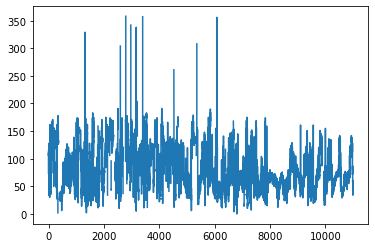

In [87]:
plt.plot(ds['WD_4062'])

In [88]:
# add attributes
if "HGHT_18" in ds:
    ds["HGHT_18"].attrs.update({'units':'m','long_name':'Height of the sea surface (m)','epic_code':'18'})
if "T_28" in ds:
    ds["T_28"].attrs.update({"units":"degree_C","long_name":"Sea Water Temperature",
         "standard_name": "sea_water_temperature","epic_code":"28"})
if "T_21" in ds:
    ds["T_21"].attrs.update({"units": "degree_C", "standard_name": "air_temperature", "epic_code": "21"})
if "BPR_915" in ds:
    ds["BPR_915"].attrs.update({"units": "mbar", "standard_name": "air_pressure", "epic_code": "915"})
if "RH_910" in ds:
    ds["RH_910"].attrs.update({"units": "percent",'long_name':'Relative Humidity',
        'standard_name': 'relative_humidity','epic_code': '910'})
if "Rn_963" in ds:
    ds["Rn_963"].attrs.update({'units': 'mm','long_name':'Rainfall Rate',
        'standard_name':'thickness_of_rainfall_amount','epic_code':'963'})
if "DP_951" in ds:
    ds["DP_951"].attrs.update({'units': 'degree_C','long_name':'Dew Point',
        'standard_name': 'dew_point','epic_code': '951'})
if "WS_401" in ds:
    ds["WS_401"].attrs.update({"units": "m/s","long_name": "mean wind speed","standard_name": "wind_speed",
        "epic_code": "401",})
if "WD_410" in ds:
    ds["WD_410"].attrs.update({"units": "degrees","long_name": "mean wind from direction relative to true north",
        "standard_name": "wind_from_direction","epic_code": "410"})
if "WG_402" in ds:
    ds["WG_402"].attrs.update({"units": "m/s","long_name": "maximum wind speed",
        "standard_name": "wind_speed_of_gust","epic_code": "402"})
if "WH_4061" in ds:
    ds["WH_4061"].attrs.update({"units": "m","long_name": "significant wave height",
        "standard_name": "significant wave height","epic_code": "4061"})
if "DWP_4063" in ds:
    ds["DWP_4063"].attrs.update({'units':'s','long_name': 'Dominant (Peak) Wave Period (s)',
        'standard_name':'sea_surface_wave_period_at_variance_spectral_density_maximum','epic_code':'4063'})
if "WD_4062" in ds:
    ds["WD_4062"].attrs.update({'units':'Degrees True','long_name':'Mean Wave Direction (deg)',
        'standard_name':"sea_surface_wave_from_direction",'epic_code':'4062'})
if "WP_4060" in ds:
    ds["WP_4060"].attrs.update({'units':'s','long_name':'Mean Wave Period (s)',
        'standard_name':"sea_surface_wave_mean_period_from_variance_spectral_density_first_frequency_moment",'epic_code':'4062'})
                                

In [93]:
ds = stglib.utils.create_z(ds)
ds = stglib.utils.ds_add_lat_lon(ds)
ds = stglib.utils.ds_coord_no_fillvalue(ds)
ds = stglib.utils.add_start_stop_time(ds)
ds["time"].attrs.update({"standard_name": "time", "axis": "T", "long_name": "time (UTC)"})
ds["time"].encoding["dtype"] = "i4"

In [94]:
ncfile = os.path.splitext(outfile)[0] + '_CF.nc' 
ds.to_netcdf(ncfile)  # write to netcdf file

In [95]:
ds.WH_4061.hvplot()

:Curve   [time]   (WH_4061)

In [96]:
MET = xr.open_dataset(ncfile)
MET

<xarray.Dataset>
Dimensions:    (time: 10998, z: 1, depth: 1, latitude: 1, longitude: 1)
Coordinates:
  * time       (time) datetime64[ns] 2023-04-25T15:00:00 ... 2023-12-27T13:30:00
  * z          (z) int64 21
  * depth      (depth) int64 0
  * latitude   (latitude) float64 26.0
  * longitude  (longitude) float64 -80.1
Data variables:
    WH_4061    (time) float64 ...
    DWP_4063   (time) float64 ...
    WP_4060    (time) float64 ...
    WD_4062    (time) float64 ...
    T_21       (time) float64 ...
    T_28       (time) float64 ...
Attributes:
    latitude:                   26.001
    longitude:                  -80.096
    LatLonDatum:                NAD83
    site_elevation:             0
    air_temp_height:            2
    sea_temp_depth:             0.46
    initial_instrument_height:  21
    WATER_DEPTH:                21
    start_time:                 2023-04-25T15:00:00.000000000
    stop_time:                  2023-12-27T13:30:00.000000000

In [97]:
MET.WP_4060.hvplot()

:Curve   [time]   (WP_4060)